# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

*Something here about what we're doing*

## Import Libraries

In [34]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [35]:
pp = pprint.PrettyPrinter(indent=4)

In [36]:
#from spotify import get_features

In [37]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [38]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [39]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [40]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [41]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [42]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [43]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [44]:
# add some code here to randomize selection

In [45]:
path = './mpd.slice.0-999.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [46]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [47]:
playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN        None   1493424000        Throwbacks   
1         false         NaN        None   1506556800  Awesome Playlist   
2         false         NaN        None   1505692800           korean    
3         false         NaN        None   1501027200               mat   
4         false         NaN        None   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

Get the features for each playlist (with our progress bar!)

In [48]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [49]:
len(feature_data)

31659

In [50]:
failures = 0
# iterate over all playlists
for index, row in playlists.iterrows():
    # render progress bar
    progress_bar(index + 1,playlists.shape[0], failures)
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    artists = set({})
    albums = set({})
    
#     artists = Counter()
#     counters = set(["artists"])
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop
        # add data from our seen songs
        for song in seen:
            song_features.append(feature_data[song])
#             temp = ''
#             for genre in genre_data[song]:
#                 if len(genre) == 1:
#                     print(genre)
            if type(genre_data[song]) == list:
                for genre in genre_data[song]:
                    genres[genre] += 1
            else:
#                 print(genre_data[song])
                genres[genre_data[song]] += 1
            popularity.append(popularity_data[song])
            years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        

        # insert all information into features dict
        for song in song_features:
            for feature in all_features:

                features[feature] += song[feature]
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
    except Exception as ex:
        print(ex)
        failures += 1



'|##############################| (1000/1000) with 2 failures'

In [53]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [51]:

playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN      221777   1493424000        Throwbacks   
1         false         NaN      298844   1506556800  Awesome Playlist   
2         false         NaN      219375   1505692800           korean    
3         false         NaN      229575   1501027200               mat   
4         false         NaN      255014   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          47           37          6              1          52   
1          23           21          5              1          39   
2          51           31         18              1          64   
3         107           86          4              1         126   
4          16           16          7              2          17   

       ...        liveness loudness      mode speechiness time_signature  \
0      ...        0.192127 -4.88194  0.692308    0.107021              4   
1      ...        0.178433 -8.29167  0.538462   0.0884487              4   
2      ...        0.169028 -4.87416  0.515625   0.0962875              4   
3      ...        0.188585 -9.61494  0.714286   0.0671857              4   
4      ...        0.166524 -7.63447  0.823529   0.0411588              4   

     tempo   valence  year popularity          genre  
0  123.007  0.642904  2004         61  post-teen pop  
1   122.67  0.476667  1981         59           rock  
2  114.601  0.565078  2017         48          k-pop  
3  125.032  0.451623  2015         34        preverb  
4   127.76  0.490765  1997         49           rock  

[5 rows x 27 columns]

In [54]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

acousticness  danceability    duration_ms      energy  \
count    998.000000    998.000000     998.000000  998.000000   
mean       0.253855      0.603369  233375.532839    0.630407   
std        0.182264      0.093280   27348.276650    0.134648   
min        0.001561      0.224467  101610.818182    0.041362   
25%        0.129298      0.542965  218686.745455    0.568575   
50%        0.199471      0.605306  230886.416667    0.648719   
75%        0.319846      0.670638  245570.362539    0.724076   
max        0.989923      0.844500  411149.050000    0.934023   

       instrumentalness         key    liveness    loudness        mode  \
count        998.000000  998.000000  998.000000  998.000000  998.000000   
mean           0.056627    5.155304    0.188250   -7.457840    0.664106   
std            0.120874    0.685701    0.047102    2.499715    0.151138   
min            0.000000    0.571429    0.098562  -30.449077    0.100000   
25%            0.001776    4.800617    0.162591   -8.340720    0.555556   
50%            0.013337    5.150982    0.183191   -6.873491    0.656451   
75%            0.053290    5.524556    0.204852   -5.860504    0.777778   
max            0.914923    9.000000    0.717087   -3.591700    1.000000   

       speechiness  time_signature       tempo     valence  
count   998.000000      998.000000  998.000000  998.000000  
mean      0.092966        3.989980  121.053396    0.491398  
std       0.059301        0.099647    7.108603    0.123440  
min       0.030320        3.000000   83.653125    0.102700  
25%       0.051080        4.000000  116.694232    0.415734  
50%       0.074148        4.000000  121.306305    0.488575  
75%       0.114790        4.000000  125.148794    0.573700  
max       0.788187        4.000000  153.919429    0.898061

## Clean Up Data
Remove entries for which we couldn't get all song data

In [55]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(998, 27)


collaborative description    duration_ms  modified_at              name  \
0         false         NaN  221777.461538   1493424000        Throwbacks   
1         false         NaN  298844.128205   1506556800  Awesome Playlist   
2         false         NaN  219374.875000   1505692800           korean    
3         false         NaN  229575.055556   1501027200               mat   
4         false         NaN  255014.352941   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          47           37          6              1          52   
1          23           21          5              1          39   
2          51           31         18              1          64   
3         107           86          4              1         126   
4          16           16          7              2          17   

       ...        liveness  loudness      mode  speechiness  time_signature  \
0      ...        0.192127 -4.881942  0.692308     0.107021             4.0   
1      ...        0.178433 -8.291667  0.538462     0.088449             4.0   
2      ...        0.169028 -4.874156  0.515625     0.096288             4.0   
3      ...        0.188585 -9.614937  0.714286     0.067186             4.0   
4      ...        0.166524 -7.634471  0.823529     0.041159             4.0   

        tempo   valence  year  popularity          genre  
0  123.006885  0.642904  2004          61  post-teen pop  
1  122.669615  0.476667  1981          59           rock  
2  114.600672  0.565078  2017          48          k-pop  
3  125.032413  0.451623  2015          34        preverb  
4  127.759882  0.490765  1997          49           rock  

[5 rows x 27 columns]

Select playlists with at least 20 songs

In [56]:
big_data = clean_data[clean_data["num_tracks"] > 10]
print(big_data.shape)
big_data.head()

(947, 27)


collaborative description    duration_ms  modified_at              name  \
0         false         NaN  221777.461538   1493424000        Throwbacks   
1         false         NaN  298844.128205   1506556800  Awesome Playlist   
2         false         NaN  219374.875000   1505692800           korean    
3         false         NaN  229575.055556   1501027200               mat   
4         false         NaN  255014.352941   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  \
0          47           37          6              1          52   
1          23           21          5              1          39   
2          51           31         18              1          64   
3         107           86          4              1         126   
4          16           16          7              2          17   

       ...        liveness  loudness      mode  speechiness  time_signature  \
0      ...        0.192127 -4.881942  0.692308     0.107021             4.0   
1      ...        0.178433 -8.291667  0.538462     0.088449             4.0   
2      ...        0.169028 -4.874156  0.515625     0.096288             4.0   
3      ...        0.188585 -9.614937  0.714286     0.067186             4.0   
4      ...        0.166524 -7.634471  0.823529     0.041159             4.0   

        tempo   valence  year  popularity          genre  
0  123.006885  0.642904  2004          61  post-teen pop  
1  122.669615  0.476667  1981          59           rock  
2  114.600672  0.565078  2017          48          k-pop  
3  125.032413  0.451623  2015          34        preverb  
4  127.759882  0.490765  1997          49           rock  

[5 rows x 27 columns]

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [57]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

In [58]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


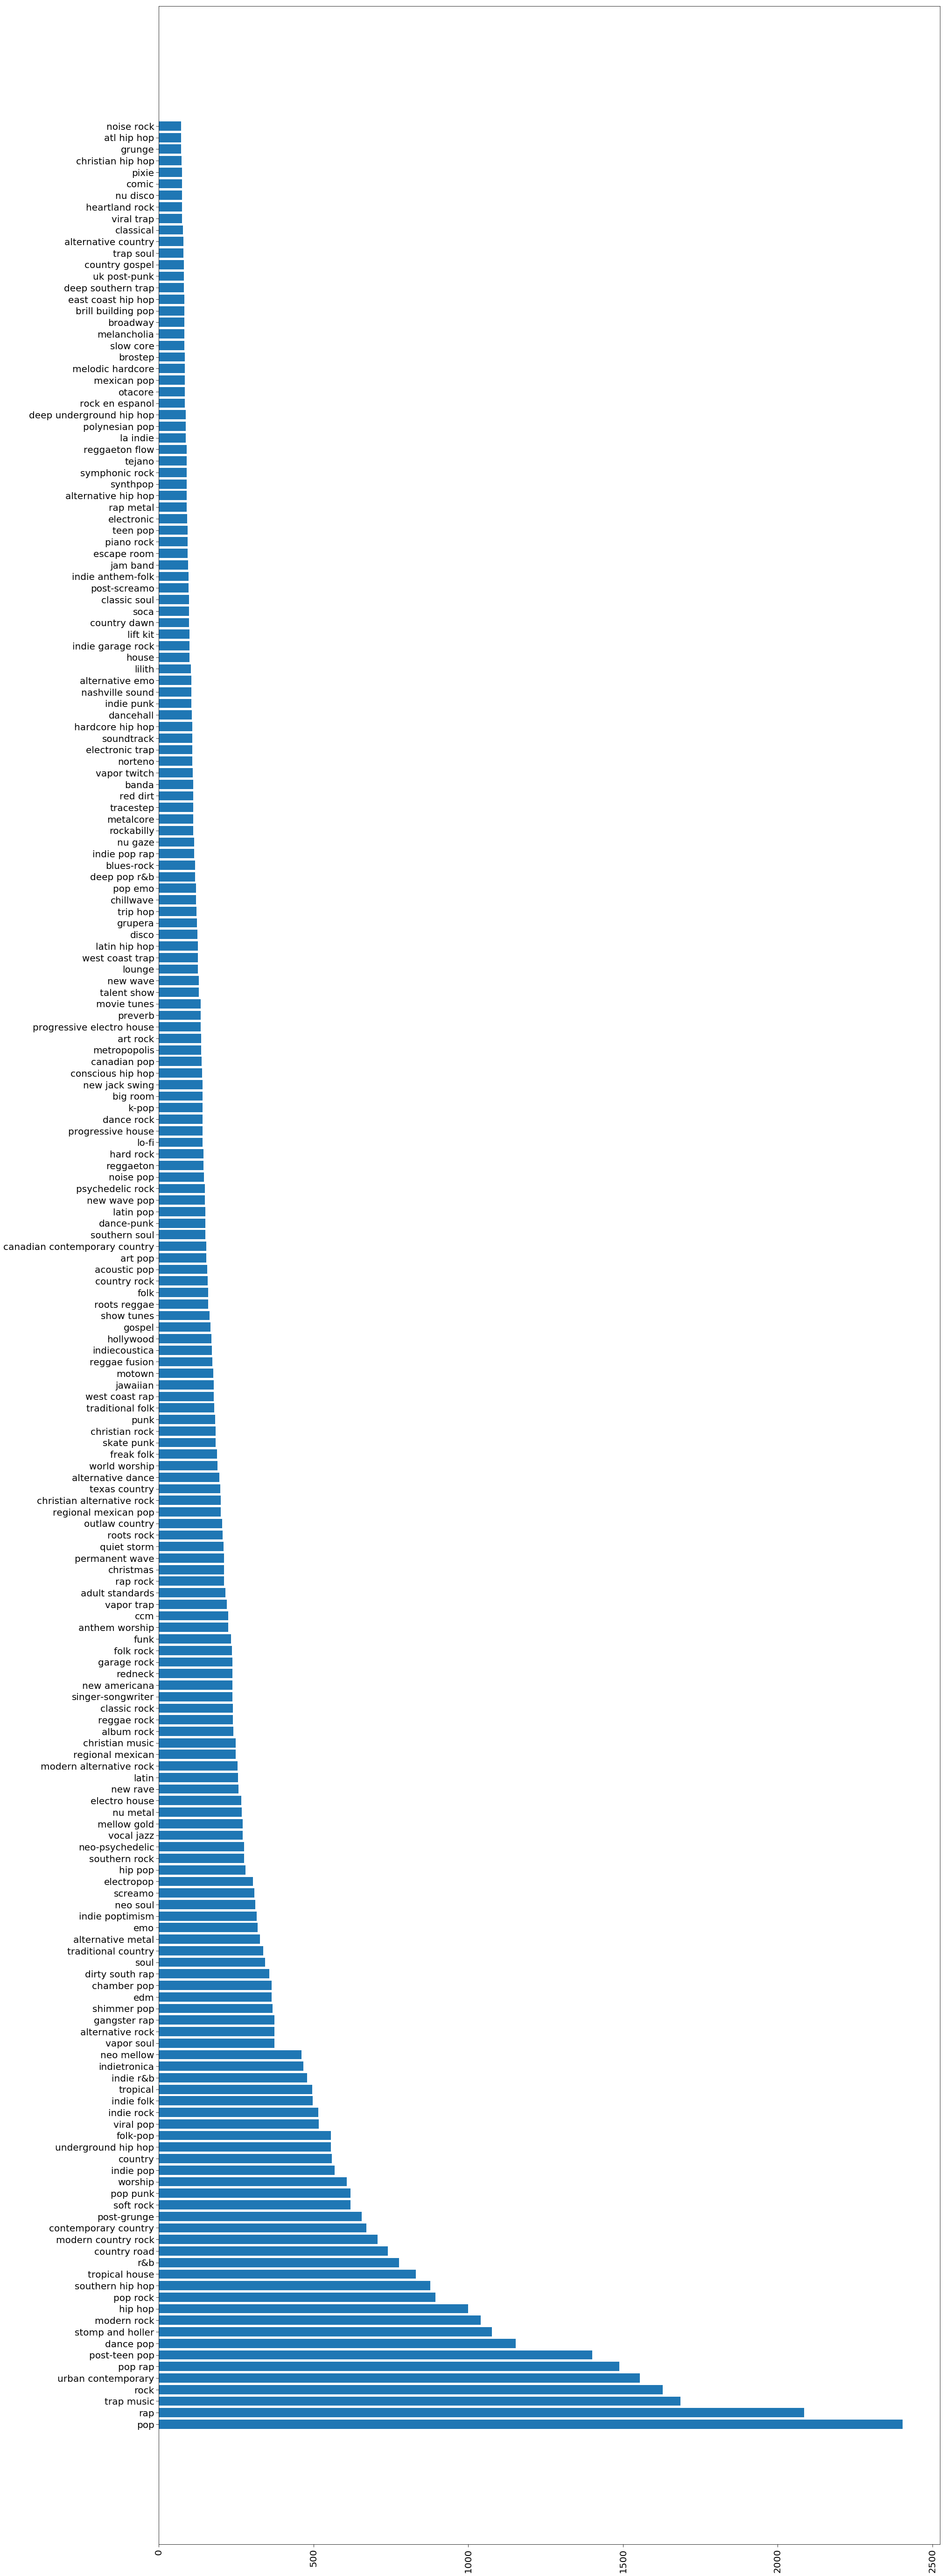

In [59]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


Observations are in EDA write-up

## Split train and test data

In [61]:
train_data, test_data = train_test_split(big_data, test_size=0.2, random_state=42)

In [62]:
train_data.shape, test_data.shape

((757, 27), (190, 27))

In [63]:
train_data.head()

collaborative description    duration_ms  modified_at       name  \
117         false         NaN  225814.692308   1476489600  Fall 2015   
84          false         NaN  268093.000000   1500940800   Workout2   
577         false         NaN  250592.096774   1492387200      sound   
888         false         NaN  267549.363636   1442880000   Old Rock   
89          false         NaN  252306.043478   1489276800       80's   

     num_albums  num_artists  num_edits  num_followers  num_tracks  \
117          13           13          7              1          13   
84           35           26         17              1          39   
577          26           21          6              1          31   
888          20           17         10              1          22   
89           85           82          2              1          92   

         ...        liveness  loudness      mode  speechiness  time_signature  \
117      ...        0.224615 -7.074923  0.846154     0.041585             4.0   
84       ...        0.265772 -5.514538  0.538462     0.226328             4.0   
577      ...        0.181268 -8.820871  0.967742     0.077768             4.0   
888      ...        0.168632 -9.355091  0.818182     0.046186             4.0   
89       ...        0.145271 -9.562924  0.739130     0.051257             4.0   

          tempo   valence  year  popularity          genre  
117  124.307692  0.628462  2015          15  texas country  
84   124.366872  0.473167  2003          59            rap  
577  123.899387  0.580581  1970          45      soft rock  
888  113.697227  0.505136  1989        59.5      soft rock  
89   119.345674  0.668054  1985        61.5      soft rock  

[5 rows x 27 columns]

In [64]:
def make_row(track_id, row):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
#                     print(feature)
            features[feature] = abs(features[feature] - row[feature])
    popularity = abs(popularity_data[track_id] - row['popularity'])
    features["popularity"] = int(popularity)
    return features

In [ ]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)
    
train_data_songs = train_data_songs.set_index("id")


# remove = ['tracks', "collaborative", "description", "modified_at", "name", "num_edits", "num_followers", "pid"]

# train_data_y = train_data["tracks"]
# train_data_x = train_data[train_data.columns.difference(remove)]
# for index, row in train_data.iterrows():
#     random.shuffle(row["tracks"])
#     train_data_y.append(row["tracks"][-5:])
# #     train_data_x.at[index,"tracks"] = row["tracks"][:-5]

'|#############################| (741/757) with 0 failures'

In [ ]:
train_data_songs.head()

In [ ]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

In [ ]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [ ]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

In [43]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

acousticness  danceability        energy  instrumentalness  \
count  22703.000000  22703.000000  2.270300e+04      22703.000000   
mean       0.242733      0.239912  2.772530e-01          0.116729   
std        0.208007      0.186428  1.963681e-01          0.206340   
min        0.000024      0.000011  5.551115e-17          0.000000   
25%        0.084868      0.084816  1.127009e-01          0.005763   
50%        0.176221      0.188934  2.391515e-01          0.027665   
75%        0.350516      0.371333  4.163456e-01          0.111532   
max        0.989608      0.839788  9.346377e-01          0.976804   

                key      liveness      loudness          mode   speechiness  \
count  22703.000000  22703.000000  22703.000000  22703.000000  22703.000000   
mean       2.884197      0.116595      6.861171      0.396436      0.076511   
std        1.762518      0.109635      6.746574      0.221631      0.083422   
min        0.000000      0.000002      0.000096      0.000000      0.000010   
25%        1.323861      0.053070      1.812657      0.222222      0.021627   
50%        2.914894      0.093149      4.756455      0.391753      0.049927   
75%        4.311539      0.141580      9.789713      0.544554      0.104749   
max        8.187500      0.876444     78.334243      1.000000      0.896186   

              tempo       valence    popularity  
count  22703.000000  22703.000000  22703.000000  
mean      44.830758      0.244563     21.612694  
std       37.406687      0.160097     16.518050  
min        0.008143      0.000026      0.000000  
25%       14.020580      0.110410      8.000000  
50%       31.795818      0.227581     18.000000  
75%       75.541616      0.357180     32.000000  
max      149.215250      0.880061     78.000000

In [60]:
train_data_songs.columns
# for col in train_data_songs.co

NameError: name 'train_data_songs' is not defined

In [44]:
train_data_x = train_data_songs[columns]
train_data_x.head()

acousticness  danceability    energy  \
id                                                             
4s40tMs2lqA6h0HPmqPDkZ      0.243023      0.211154  0.096462   
6imjmdYzqJS03o0YrPq06V      0.213453      0.098846  0.162538   
0vNTlunI1KuAEM9N1bqH13      0.193953      0.123154  0.254462   
5iO05Xt731nYIHxxumLIpT      0.160053      0.095846  0.040462   
3VLdNTLmKpXu79TMCeRbLO      0.543447      0.000846  0.393538   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
4s40tMs2lqA6h0HPmqPDkZ          0.001740  5.076923  0.103615  3.200923   
6imjmdYzqJS03o0YrPq06V          0.001730  0.923077  0.020385  3.644077   
0vNTlunI1KuAEM9N1bqH13          0.001730  2.923077  0.069615  4.564923   
5iO05Xt731nYIHxxumLIpT          0.001468  0.076923  0.040385  0.227923   
3VLdNTLmKpXu79TMCeRbLO          0.001594  1.076923  0.106615  3.953077   

                            mode  speechiness time_signature      tempo  \
id                                                                        
4s40tMs2lqA6h0HPmqPDkZ  0.153846     0.003685              0  40.115308   
6imjmdYzqJS03o0YrPq06V  0.153846     0.012285              0   6.402692   
0vNTlunI1KuAEM9N1bqH13  0.153846     0.025515              0  55.742308   
5iO05Xt731nYIHxxumLIpT  0.153846     0.015085              0   1.266692   
3VLdNTLmKpXu79TMCeRbLO  0.153846     0.012685              0  19.904692   

                         valence  popularity  
id                                            
4s40tMs2lqA6h0HPmqPDkZ  0.262462        10.0  
6imjmdYzqJS03o0YrPq06V  0.078538        15.0  
0vNTlunI1KuAEM9N1bqH13  0.040538        29.0  
5iO05Xt731nYIHxxumLIpT  0.039538        15.0  
3VLdNTLmKpXu79TMCeRbLO  0.460462         9.0

In [46]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index < 10:
            track_id = track["track_uri"].split(':')[-1]
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
    
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
train_data_x.head()

'|##############################| (190/190) with 0 failures'

acousticness  danceability    energy  \
id                                                             
4s40tMs2lqA6h0HPmqPDkZ      0.243023      0.211154  0.096462   
6imjmdYzqJS03o0YrPq06V      0.213453      0.098846  0.162538   
0vNTlunI1KuAEM9N1bqH13      0.193953      0.123154  0.254462   
5iO05Xt731nYIHxxumLIpT      0.160053      0.095846  0.040462   
3VLdNTLmKpXu79TMCeRbLO      0.543447      0.000846  0.393538   

                        instrumentalness       key  liveness  loudness  \
id                                                                       
4s40tMs2lqA6h0HPmqPDkZ          0.001740  5.076923  0.103615  3.200923   
6imjmdYzqJS03o0YrPq06V          0.001730  0.923077  0.020385  3.644077   
0vNTlunI1KuAEM9N1bqH13          0.001730  2.923077  0.069615  4.564923   
5iO05Xt731nYIHxxumLIpT          0.001468  0.076923  0.040385  0.227923   
3VLdNTLmKpXu79TMCeRbLO          0.001594  1.076923  0.106615  3.953077   

                            mode  speechiness time_signature      tempo  \
id                                                                        
4s40tMs2lqA6h0HPmqPDkZ  0.153846     0.003685              0  40.115308   
6imjmdYzqJS03o0YrPq06V  0.153846     0.012285              0   6.402692   
0vNTlunI1KuAEM9N1bqH13  0.153846     0.025515              0  55.742308   
5iO05Xt731nYIHxxumLIpT  0.153846     0.015085              0   1.266692   
3VLdNTLmKpXu79TMCeRbLO  0.153846     0.012685              0  19.904692   

                         valence  popularity  
id                                            
4s40tMs2lqA6h0HPmqPDkZ  0.262462        10.0  
6imjmdYzqJS03o0YrPq06V  0.078538        15.0  
0vNTlunI1KuAEM9N1bqH13  0.040538        29.0  
5iO05Xt731nYIHxxumLIpT  0.039538        15.0  
3VLdNTLmKpXu79TMCeRbLO  0.460462         9.0

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=250)
logreg.fit(train_data_x, train_data_y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
coefs = zip(train_data_x.columns, logreg.coef_[0])
# print(list(coefs))
# print(logreg.coef_)
# print(train_data_x.columns)
# logreg.coef_

[('acousticness', 0.019084879457402042), ('danceability', -0.12317317487697946), ('energy', 0.018615373310492345), ('instrumentalness', 0.124873472876299), ('key', -0.004559730626635736), ('liveness', 0.09669683393820624), ('loudness', -0.003425070384646064), ('mode', -0.002926977501903132), ('speechiness', -0.01982533214189043), ('time_signature', -0.018188135200537973), ('tempo', -0.001071041455519947), ('valence', -0.050013891034148994), ('popularity', 0.015803524308805897)]


In [56]:
logreg.score(test_data_x, test_data_y)

0.7554208754208754

In [16]:
limit = 5
lastfmkey = "b4c63b3d7fb0c8d3ed670d8d78d737df"
def get_song_similar(song, artist):
    data = {'api_key': lastfmkey, 'artist': artist, 'track': song, 'limit': limit}
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=track.getsimilar&format=json', data=data)
    pp.pprint(response.content)